In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/10academy/week 4/Data/train.csv')
store_df = pd.read_csv('/content/drive/MyDrive/10academy/week 4/Data/store.csv')

# Merging data
data = pd.merge(train_df, store_df, on='Store')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Filtering by one store for time series (e.g., Store 1)
store_sales = data[data['Store'] == 1][['Date', 'Sales']].set_index('Date')
store_sales = store_sales.resample('D').sum()  # Resample to ensure daily data

<ipython-input-30-e1fb0498786a>:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/content/drive/MyDrive/10academy/week 4/Data/train.csv')


In [ ]:
# Function to perform ADF test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

adf_test(store_sales['Sales'])

ADF Statistic: -4.3681043681685
p-value: 0.0003378834614142435
Critical Values:
   1%: -3.4374778690219956
   5%: -2.864686684217556
   10%: -2.5684454926748583


In [ ]:
# Differencing the data
store_sales['Sales_diff'] = store_sales['Sales'].diff().dropna()

# ADF test on differenced data
adf_test(store_sales['Sales_diff'].dropna())

ADF Statistic: -11.494179384893501
p-value: 4.657503151741684e-21
Critical Values:
   1%: -3.4374778690219956
   5%: -2.864686684217556
   10%: -2.5684454926748583


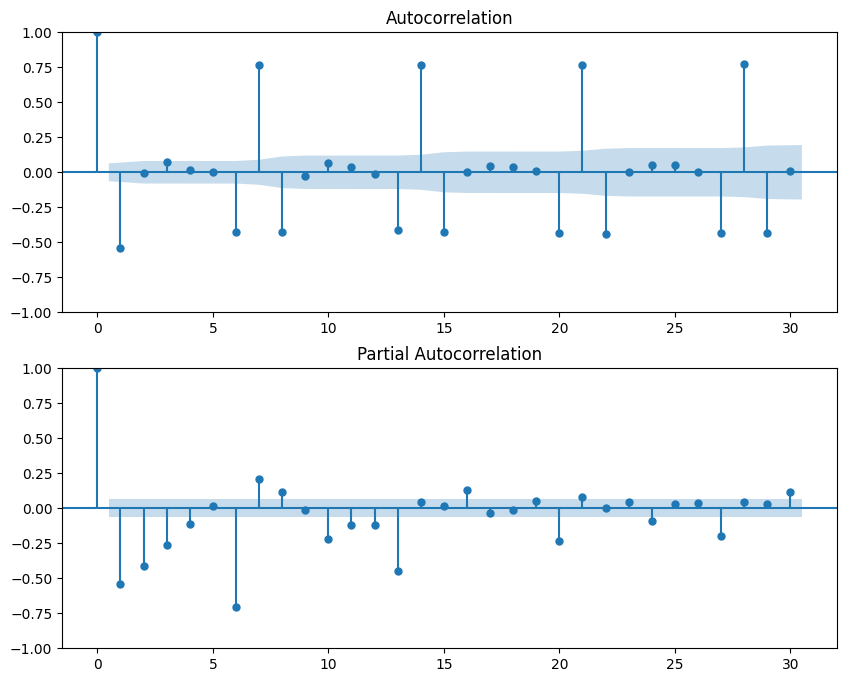

In [ ]:
# Autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(2, figsize=(10,8))
plot_acf(store_sales['Sales_diff'].dropna(), ax=ax[0])
plot_pacf(store_sales['Sales_diff'].dropna(), ax=ax[1])
plt.show()

In [ ]:
# Sliding window method to create supervised learning data
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        label = data[i+window_size]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 30  # 30 days sliding window
scaled_sales = MinMaxScaler(feature_range=(-1, 1)).fit_transform(store_sales[['Sales']].dropna())
X, y = create_sequences(scaled_sales, window_size)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)  # lstm_out shape: (batch_size, sequence_length, hidden_size)
        lstm_out_last = lstm_out[:, -1, :]  # Extract the last time step, shape: (batch_size, hidden_size)
        predictions = self.linear(lstm_out_last)  # Pass through the linear layer, shape: (batch_size, output_size)
        return predictions

In [ ]:
criterion = nn.MSELoss()

In [ ]:
import torch.optim as optim

# Hyperparameters
input_size = 1  # You have only one feature (Sales)
hidden_layer_size = 64  # This can be tuned
output_size = 1  # You want to predict one value (next sales)

# Initialize model, criterion, and optimizer
model = LSTMModel(input_size, hidden_layer_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    y_pred = model(X)  # Forward pass
    loss = criterion(y_pred, y)  # Compute loss

    loss.backward()  # Backpropagation
    optimizer.step()  # Update model parameters

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.18899303674697876
Epoch 10, Loss: 0.17966125905513763
Epoch 20, Loss: 0.17918701469898224
Epoch 30, Loss: 0.17871995270252228
Epoch 40, Loss: 0.17842905223369598


In [ ]:
def predict_sales(model, input_data, steps):
    model.eval()
    predictions = []
    input_seq = input_data[-window_size:]  # Start with the last known window
    input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)  # Shape: (1, window_size, 1)

    for _ in range(steps):
        with torch.no_grad():
            pred = model(input_seq)  # Forward pass, pred shape: (1, 1)
            predictions.append(pred.item())  # Add prediction to list

            # Prepare the input sequence for the next time step
            pred = pred.unsqueeze(2)  # Change pred shape to (1, 1, 1) to match input_seq's last dimension
            input_seq = torch.cat((input_seq[:, 1:], pred), dim=1)  # Concatenate along the time dimension

    return predictions

In [ ]:
predictions = predict_sales(model, scaled_sales, steps=42)

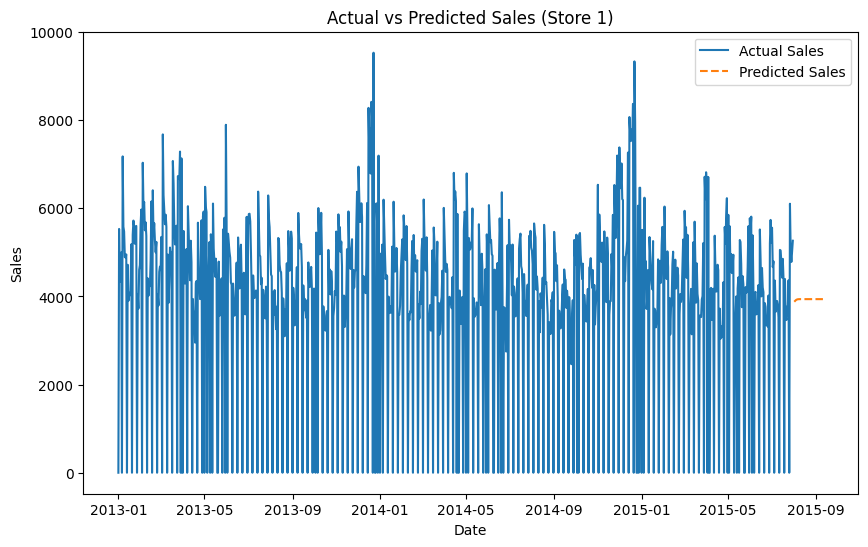

In [ ]:
# Create a timeline for the predicted sales (42 days ahead)
future_dates = pd.date_range(start=store_sales.index[-1], periods=42 + 1, inclusive='right')

# Convert predictions back to the original scale
predictions = np.array(predictions).reshape(-1, 1)
predictions_original_scale = scaler.inverse_transform(predictions)

# Correctly use future_dates for plotting
# We will plot the first 41 predictions to match the dates
plt.figure(figsize=(10, 6))
plt.plot(store_sales.index, store_sales['Sales'], label='Actual Sales')
plt.plot(future_dates[1:], predictions_original_scale[:-1], label='Predicted Sales', linestyle='--')  # Exclude the last prediction
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (Store 1)')
plt.legend()
plt.show()